In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FER 2013 Dataset.zip to FER 2013 Dataset.zip


In [ ]:
!unzip "FER 2013 Dataset.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/FER 2013 Dataset/train/sad/im370.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3700.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3701.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3702.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3703.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3704.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3705.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3706.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3707.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3708.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3709.png  
  inflating: /content/FER 2013 Dataset/train/sad/im371.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3710.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3711.png  
  inflating: /content/FER 2013 Dataset/train/sad/im3712.png  
  inflating: /content

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape


In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

DATASET_PATH = "/content/FER 2013 Dataset"
IMG_SIZE = (48, 48)
SEQUENCE_LENGTH = 10  # You can increase if there are more images per class
X, y = [], []

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

# Go through both train and test folders
for split in ['train', 'test']:
    split_path = os.path.join(DATASET_PATH, split)
    for class_folder in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        images = sorted([
            os.path.join(class_path, img)
            for img in os.listdir(class_path)
            if img.lower().endswith(valid_exts)
        ])

        if len(images) < SEQUENCE_LENGTH:
            print(f"⛔ Skipping '{split}/{class_folder}' — only {len(images)} images")
            continue

        for i in range(0, len(images) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
            sequence = []
            for j in range(SEQUENCE_LENGTH):
                img_path = images[i + j]
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"⚠️ Failed to read: {img_path}")
                    continue
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0
                sequence.append(img)

            if len(sequence) == SEQUENCE_LENGTH:
                X.append(sequence)
                y.append(class_folder)

# Convert to NumPy array
X = np.array(X)[..., np.newaxis]  # Add channel dim
print("✅ Final X shape:", X.shape)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)
print("✅ Encoded Classes:", le.classes_)
print("✅ Final y shape:", y_cat.shape)


✅ Final X shape: (3583, 10, 48, 48, 1)
✅ Encoded Classes: ['angry' 'disgusted' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
✅ Final y shape: (3583, 7)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (2866, 10, 48, 48, 1) | Test shape: (717, 10, 48, 48, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(10, 48, 48, 1)),
    TimeDistributed(MaxPooling2D(2,2)),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(2,2)),
    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')  # 18 output classes
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 46, 46, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 23, 23, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 23, 23, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 21, 21, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 6400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,503 (12.86 MB)

 Trainable params: 3,370,439 (12.86 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Models/FER Dataset LSTM.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop, checkpoint]
)


In [ ]:
from keras.models import load_model
model=load_model('/content/drive/MyDrive/Models/LSTM on FER Dataset.keras')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - accuracy: 0.8781 - loss: 0.4600
✅ Final Test Accuracy: 0.8884, Test Loss: 0.3906


In [ ]:
model.save('/content/drive/MyDrive/Models/LSTM on FER Dataset.keras')

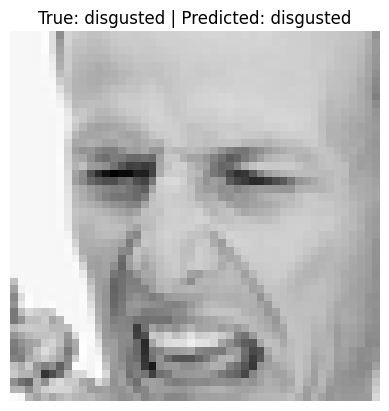

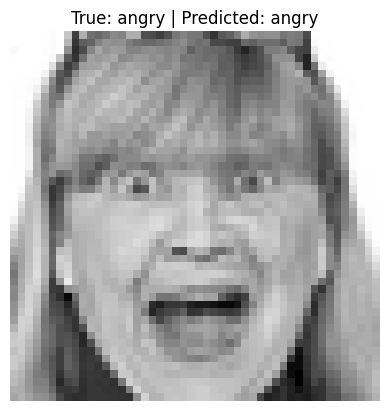

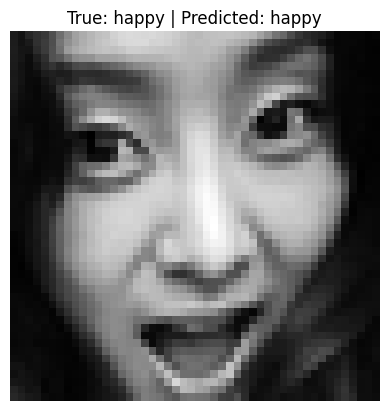

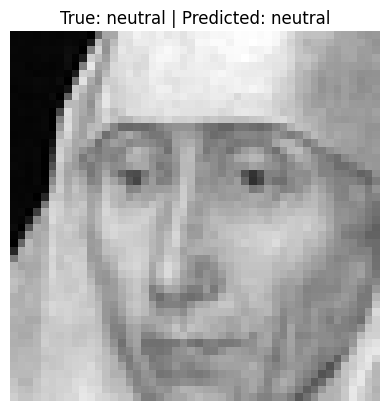

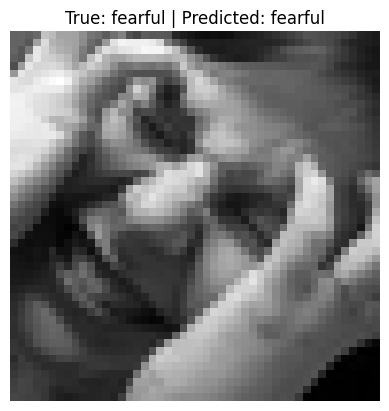

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

FER_TEST_PATH = "/content/FER 2013 Dataset/test"
SEQUENCE_LENGTH = 10

model = load_model('/content/drive/MyDrive/Models/LSTM on FER Dataset.keras')

emotion_labels = sorted(os.listdir(FER_TEST_PATH))
le = LabelEncoder()
le.fit(emotion_labels)

def preprocess_sequence(image_paths):
    sequence = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        img = cv2.resize(img, (48, 48))
        img = img / 255.0
        sequence.append(img)
    if len(sequence) != SEQUENCE_LENGTH:
        return None
    return np.array(sequence)[..., np.newaxis]

for _ in range(5):
    class_name = random.choice(emotion_labels)
    class_folder = os.path.join(FER_TEST_PATH, class_name)

    images = sorted([
        os.path.join(class_folder, f)
        for f in os.listdir(class_folder)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    ])

    if len(images) < SEQUENCE_LENGTH:
        continue

    start_idx = random.randint(0, len(images) - SEQUENCE_LENGTH)
    sequence_paths = images[start_idx:start_idx + SEQUENCE_LENGTH]

    sequence = preprocess_sequence(sequence_paths)
    if sequence is None:
        continue

    prediction = model.predict(np.expand_dims(sequence, axis=0), verbose=0)
    predicted_label = le.classes_[np.argmax(prediction)]
    true_label = class_name

    plt.imshow(sequence[0].squeeze(), cmap='gray')
    plt.title(f"True: {true_label} | Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
